# Import necessary libraries and data


In [2]:
!pip install pandas numpy seaborn matplotlib scikit-learn shap eli5 lime


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import shap
import eli5
from eli5.sklearn import PermutationImportance
from lime.lime_tabular import LimeTabularExplainer

In [28]:
# Load the Titanic dataset
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
data = pd.read_csv(url)

# EDA

In [7]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
data.info

<bound method DataFrame.info of      PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                   

In [23]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Visualize the distribution of the 'Survived' column


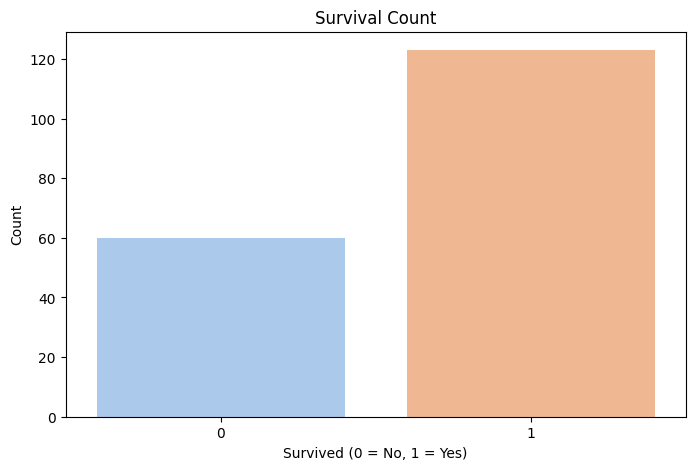

In [43]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Survived', data=df, palette='pastel')
plt.title('Survival Count')
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

### Explore the relationship between 'Pclass' and 'Survived'


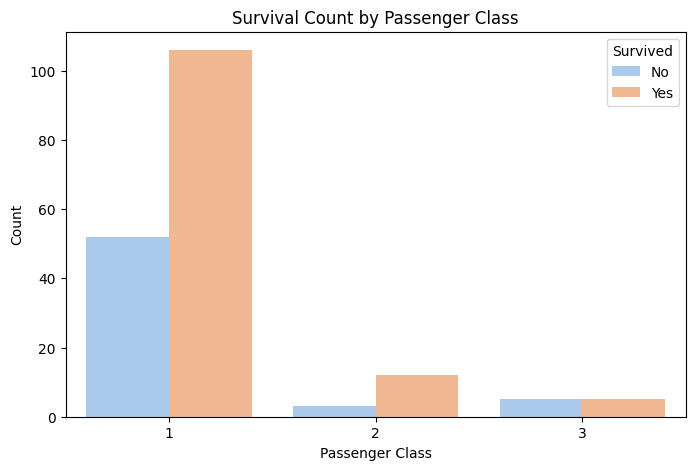

In [44]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Pclass', hue='Survived', data=df, palette='pastel')
plt.title('Survival Count by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.legend(title='Survived', loc='upper right', labels=['No', 'Yes'])
plt.show()


### Analyze the distribution of ages


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


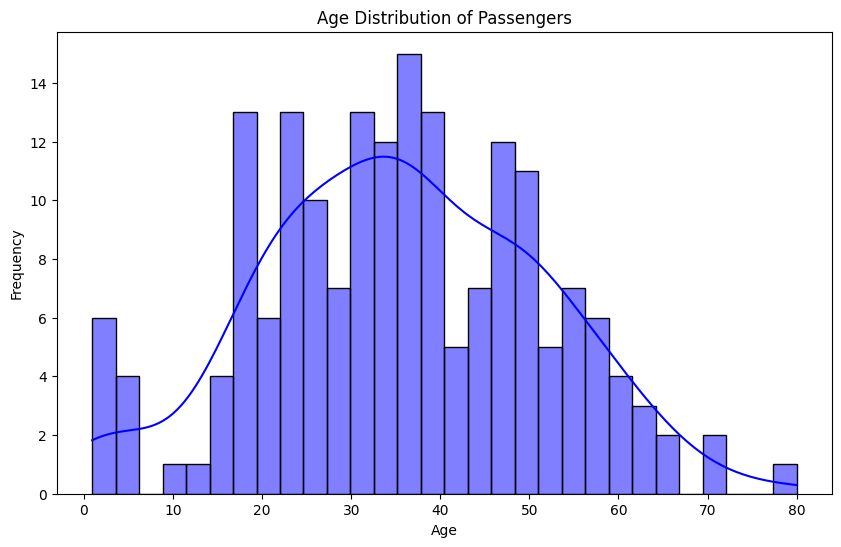

In [45]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'].dropna(), bins=30, kde=True, color='blue')
plt.title('Age Distribution of Passengers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Data preprocessing

In [29]:
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

# Fill missing values
data['Age'].fillna(data['Age'].median(), inplace=True) 
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)  

# Too many missing values
data.drop(['Cabin', 'Name', 'Ticket'], axis=1, inplace=True)
data = pd.get_dummies(data, columns=['Embarked'], drop_first=True)


X = data.drop('Survived', axis=1)
y = data['Survived']

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




# Model Eval

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       109
           1       0.74      0.73      0.73        70

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



# Analyze feature importance using Permutation Importance


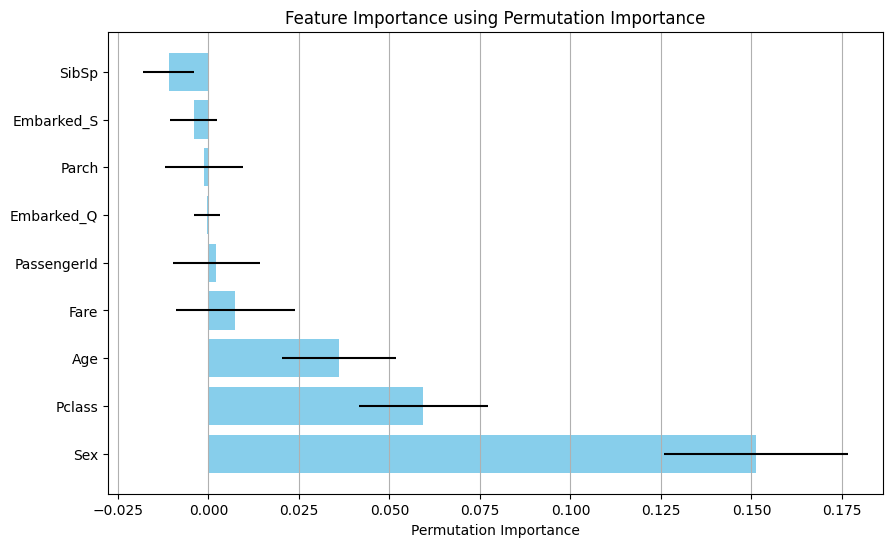

In [40]:
from sklearn.inspection import permutation_importance

results = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=3)

perm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': results.importances_mean,
    'Std': results.importances_std
})

# Sort the DataFrame by importance
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'], xerr=perm_importance_df['Std'], color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Feature Importance using Permutation Importance')
plt.grid(axis='x')
plt.show()

# Analyze SHAP values


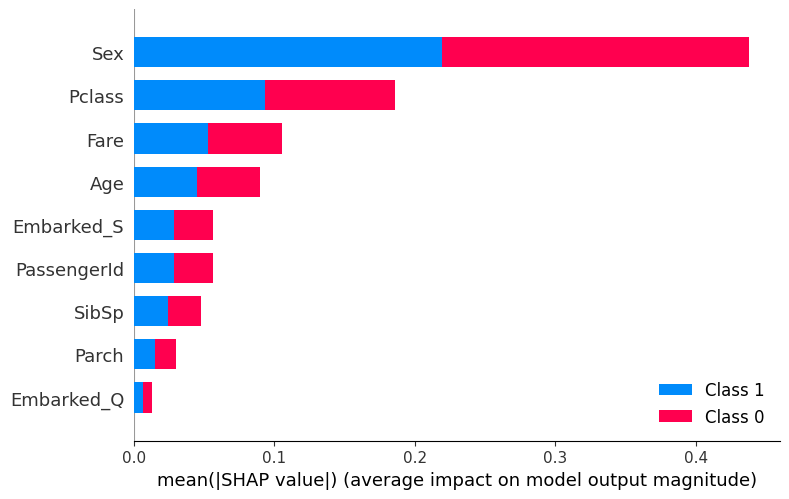

In [33]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

# LIME analysis


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


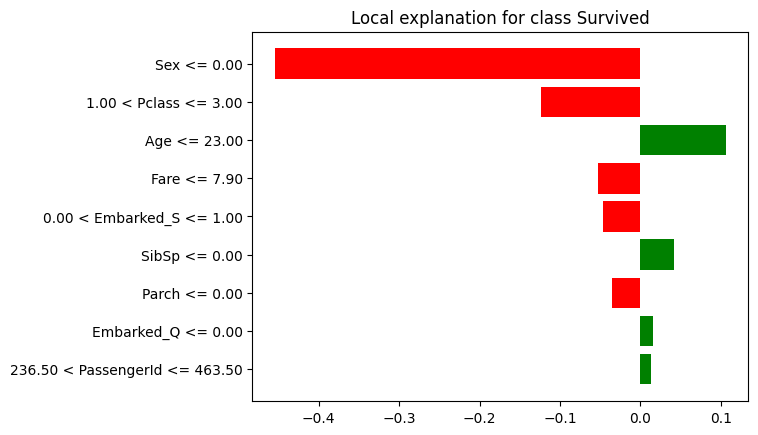

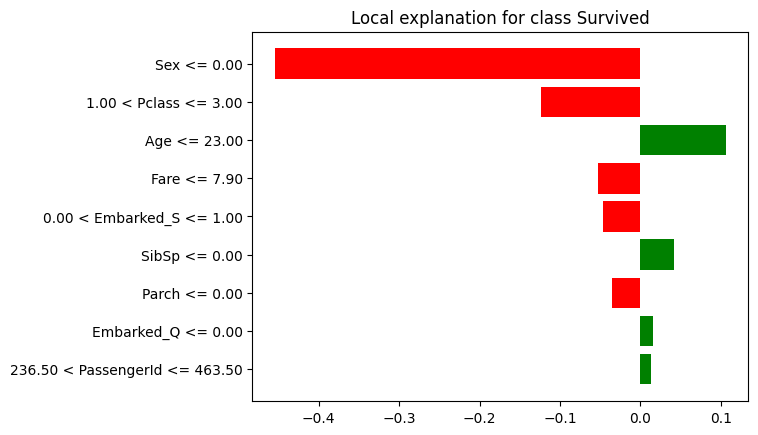

In [34]:
lime_explainer = LimeTabularExplainer(X_train.values, feature_names=X.columns, class_names=['Not Survived', 'Survived'], mode='classification')
lime_idx = 0  # Example index for LIME explanation
lime_exp = lime_explainer.explain_instance(X_test.values[lime_idx], model.predict_proba)
lime_exp.as_pyplot_figure()

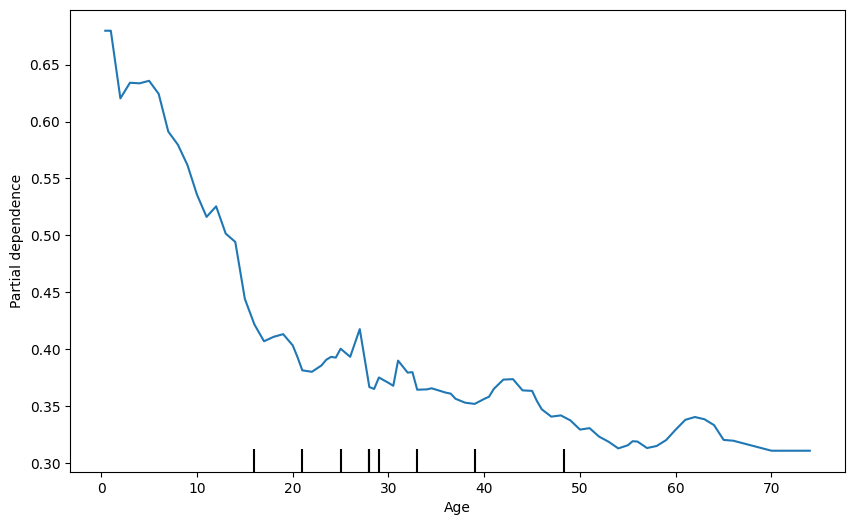

In [42]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(10, 6))  # Increase figure size
PartialDependenceDisplay.from_estimator(model, X_train, features=['Age'], ax=ax)
plt.show()

# Conclusions

- The Random Forest model showed satisfactory performance, as indicated by the classification report. Metrics such as precision, recall, and F1-score can help assess how well the model predicts survival.

- Interpretability: Using SHAP values helps to understand how individual features affect predictions for specific instances, while LIME provides localized explanations for specific predictions. These tools are vital for model interpretability, especially in sensitive applications like predicting survival.

- Partial Dependence Plots (PDPs): The PDP for Age indicates how the likelihood of survival changes with age, offering insights into age-related risks in survival chances.

The combination of feature importance analysis and model interpretation techniques provides a comprehensive view of how the model makes predictions and highlights the critical features that drive the predictions. This understanding can guide further data collection, feature engineering, and model tuning for improved accuracy.